In [3]:
field = Field(10,0.1)

In [520]:
# Revised from 'alestainer'
"""This is a gym-like environment for the game Wolfpack that allows multiple agents and message exchange between them"""

import numpy as np
import sys

ACTION_MAP = {
    'Stay': (0, 0),
    'Up': (-1, 0),
    'Left': (0, -1),
    'Down': (1, 0),
    'Right': (0, 1),
    'U L': (-1, -1),
    'U R': (-1, 1),
    'D L': (1, -1),
    'D R': (1, 1)
}


class Field(object):
    def __init__(self, size, wall_density):
        """
        
        :param size: Size of the field
        :param wall_density: Probability for each cell that it will be wall there.
        """
        self.size = size
        field = np.zeros(shape=(size, size))  # Initialize field
        for i in range(size):
            for j in range(size):
                if (field[i][j] != 2 and field[i][j] != 3):
                    field[i][j] = np.random.binomial(1, wall_density)  # Create walls in the labyrinth
        field.flags.writeable = False
        self.field = field

In [521]:
class Prey():
    def __init__(self, field):
        self.action_space = [0,1,2,3,4,5,6,7,8]
        
        
        self.coordinates = tuple(np.random.randint(0, field.size, 2))
        while (field.field[self.coordinates] == 1):
            self.coordinates = tuple(np.random.randint(0, field.size, 2))
    
    def step_(self,action):
        action = action
        move = list(ACTION_MAP.values())[action]
        coordinates = np.add(self.coordinates, move)
        
        while (coordinates[0] not in range(0, field.size)
                or coordinates[1] not in range(0, field.size)
                or field.field[tuple(coordinates)] == 1):
            action = int(np.random.choice(action_space, 1))
            move = list(ACTION_MAP.values())[action]
            coordinates = np.add(self.coordinates, move)
        self.coordinates = tuple(coordinates)
        self.action = action

In [522]:
class Hunt():
    def __init__(self, field, prey):
        self.action_space = [0,1,2,3,4,5,6,7,8]
        
        prey_coordinates = prey.coordinates
        coordinates = tuple(np.random.randint(0, field.size, 2))
        while (field.field[tuple(coordinates)] == 1 or (coordinates[0] == prey_coordinates[0] and coordinates[1] == prey_coordinates[1])):
            coordinates = tuple(np.random.randint(0, field.size, 2))
        self.coordinates = coordinates
        
    def step_(self,action):
        action = action
        move = list(ACTION_MAP.values())[action]
        coordinates = np.add(self.coordinates, move)
        
        while (coordinates[0] not in range(0, field.size)
                or coordinates[1] not in range(0, field.size)
                or field.field[tuple(coordinates)] == 1):
            action = int(np.random.choice(self.action_space, 1))
            # action = 0 
            move = list(ACTION_MAP.values())[action]
            coordinates = np.add(self.coordinates, move)
        self.coordinates = tuple(coordinates)
        self.action = action


In [183]:
Prey(field)

In [523]:
# fix prey location
class Game(object):
    def __init__(self, num_of_hunters=2, reward_distance=2,
                 field=Field(5, 0.1),prey=Prey(field)):
        """
        
        :param num_of_hunters: Number of hunters playing
        :param duration: Number of steps before interruption
        :param reward_distance: distance from which hunter is getting reward
        :param field: Field where the game is played
        """
        self.field = field
        self.done = False
        self.reward_distance = reward_distance
        self.size = field.size
        self.num_of_hunters = num_of_hunters
        self.prey = prey
        
        self.reset()  

    def get_obs(self):
        
        observations = []
        for i in range(len(self.hunters)):
            original_field = self.field.field.copy()
            hunter_postion = np.zeros(shape=(field.size,field.size))
            hunter_postion[tuple(self.hunters[i].coordinates)] = 2
            field_observation = np.zeros(shape=(field.size,field.size))
            field_observation[tuple(self.prey.coordinates)] = 3
            for j in range(len(self.hunters)):
                if j != i:
                    field_observation[tuple(self.hunters[j].coordinates)] = 2 
            # assume the agent could see its own position and the other agent
            field_final = np.stack((field_observation,hunter_postion,original_field),axis=2)
            observations.append(field_final) # , message_observation
        
        return observations
    
    
    
    def render(self):
        """
        Gives representation of the current game state
        :return: 
        """
        return sys.stdout.write(repr(self.state))

    def reset(self):
        """
        Resets the game with the same walls but with different prey and hunter coordinates
        :return:
        """

        #prey = Prey(self.field)
        hunters = []
        for i in range(self.num_of_hunters):
            hunters.append(Hunt(self.field, prey))
        #self.prey = prey
        self.hunters = hunters
        
        state = self.field.field.copy()
        state[tuple(self.prey.coordinates)] = 3
        for hunter in self.hunters:
            state[tuple(hunter.coordinates)] = 2

        self.state = state
        self.done = False


    def calculate_reward(self):
        """
        
        :return: Vector of rewards
        """
        rewards = np.zeros(len(self.hunters))
        for i, hunter in enumerate(self.hunters):
            if np.sqrt((hunter.coordinates[0] - self.prey.coordinates[0]) ** 2
                               + (hunter.coordinates[1] - self.prey.coordinates[1]) ** 2) < self.reward_distance:
                rewards[i] = 1

        multiplier = sum(rewards)
        return rewards * multiplier

    def step(self, actions):
        """
        One basic step in the environment
        :param actions: Set of hunter's actions
        :return: 
        """
        # assume the prey do not move, save the trainning time
        #action_space = [0,1,2,3,4,5,6,7,8]
        #prey_action = int(np.random.choice(action_space, 1))
        #self.prey.step_(prey_action)
        
        actions = actions
        for i in range(self.num_of_hunters):
            action = actions[i]
            hunter = self.hunters[i]
            hunter.step_(action)
            
        rewards = np.zeros(len(self.hunters))    
        if any((x.coordinates[0] == self.prey.coordinates[0] and x.coordinates[1] == self.prey.coordinates[1]) 
               for x in self.hunters): 
            rewards = self.calculate_reward()
            self.done = True


        state = self.field.field.copy()
        state[tuple(self.prey.coordinates)] = 3
        for hunter in self.hunters:
            state[tuple(hunter.coordinates)] = 2

        self.state = state
        
        # collect the true action
        for i in range(self.num_of_hunters):
            hunter = self.hunters[i]
            actions[i] = hunter.action
        self.actions = actions
        
        return self.get_obs(), actions, rewards, self.done

In [524]:
field=Field(5, 0.1)
prey=Prey(field)
env = Game(num_of_hunters=2, reward_distance=2,field=field,prey=prey)

In [312]:
# Multi-agent dqn
np.stack(([1,1],[1,2],[1,3]),axis=2)

array([[1, 1],
       [1, 2],
       [1, 3]])

In [525]:
import tensorflow as tf
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers import Merge
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout, Reshape
from keras import backend as K

import time

input_height = 5
input_width = 5
input_channels = 3
n_outputs = 9

In [534]:
def build_model():
    model = Sequential()

    # this applies 32 convolution filters of size 3x3 each.
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(5, 5, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    #model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
        
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation='softmax'))
    
    return model

In [535]:
tf.reset_default_graph() 
X1_state = tf.placeholder(tf.float32,shape=[None,input_height,input_width,input_channels])
X2_state = tf.placeholder(tf.float32,shape=[None,input_height,input_width,input_channels])

critic_model_a1 = build_model()
actor_model_a1 = build_model()
critic_model_a2 = build_model()
actor_model_a2 = build_model()

In [536]:
actor_q_a1 = actor_model_a1(X1_state)
critic_q_a1 = critic_model_a1(X1_state)
actor_q_a2 = actor_model_a2(X2_state)
critic_q_a2 = critic_model_a2(X2_state)

In [97]:
actor_model_a1(X1_state)

<tf.Tensor 'sequential_2/dense_4/Softmax:0' shape=(?, 9) dtype=float32>

In [537]:
# Train the model
learning_rate = 0.001
global_step = tf.Variable(0,trainable=False,name='global_step')
X1_action = tf.placeholder(tf.int32,shape=[None])
X2_action = tf.placeholder(tf.int32,shape=[None])

q1_value = tf.reduce_sum(critic_q_a1 * tf.one_hot(X1_action,n_outputs),
                       axis=1, keep_dims=True)
q2_value = tf.reduce_sum(critic_q_a2 * tf.one_hot(X2_action,n_outputs),
                       axis=1, keep_dims=True)

y1=tf.placeholder(tf.float32,shape=[None,1])
cost1 = tf.reduce_mean(tf.square(y1 - q1_value))

y2=tf.placeholder(tf.float32,shape=[None,1])
cost2 = tf.reduce_mean(tf.square(y2 - q1_value))

optimizer = tf.train.AdamOptimizer(learning_rate)
optimizer2 = tf.train.AdamOptimizer(learning_rate)

training_op = optimizer.minimize(cost1,global_step=global_step)
training_op2 = optimizer.minimize(cost2,global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()



In [538]:
from collections import deque

replay_memory_size = 10000
replay_memory = deque([],maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[],[],[],[],[]] # state, action, reward, next state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols,memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0],cols[1],cols[2].reshape(-1,1),cols[3],cols[4].reshape(-1,1))
            

In [539]:
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

def epsilon_greedy(q_values,step):
    epsilon = max(eps_min,eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values)

In [540]:
import os
n_steps = 2000000 # total number of training steps
training_start = 1000 # start training after 1000 game iterations
training_interval = 3 # run a training step every 3 game iterations
save_steps = 100 # save the model every 50 training steps
copy_steps = 50 # copy the critic to the actor every 25 training steps
discount_rate = 0.95
batch_size = 100
iteration = 0 # game iteration
done = True # env needs to be reset
checkpoint_path = "./re_dqn.ckpt"
loss = []
rewards_re = []
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        saver.restore(sess,checkpoint_path)
    else:
        init.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if env.done == 1:
            env.reset()
            
        observation, actions, rewards, done = env.step([0,0])
        state = observation
        
        #Actor evaluate waht to do
        q1_values = actor_q_a1.eval(feed_dict={X1_state: [state[0]]})
        action1 = epsilon_greedy(q1_values,step)
        
        q2_values = actor_q_a2.eval(feed_dict={X2_state: [state[1]]})
        action2 = epsilon_greedy(q2_values,step)
        
        #Actor plays
        observation, actions, rewards, done = env.step([action1,action2])
        next_state = observation
        
        #Let's memory what just happened
        replay_memory.append((state,actions,rewards,next_state,1.0 - done))
        state = next_state
        
        if iteration < training_start or iteration % training_interval !=0:
            continue
            
        # Critic learns
        X_state_val, X_action_val, rewards, X_next_state_val, continues =(sample_memories(batch_size))
        next_q1_values = actor_q_a1.eval(feed_dict = {X1_state: X_next_state_val[:,0,:,:]})
        max_next_q1_values = np.max(next_q1_values,axis=1,keepdims=True)
        next_q2_values = actor_q_a2.eval(feed_dict = {X2_state: X_next_state_val[:,1,:,:]})
        max_next_q2_values = np.max(next_q2_values,axis=1,keepdims=True)
        
        
        y1_val = rewards[0] + continues * discount_rate * max_next_q1_values
        y2_val = rewards[1] + continues * discount_rate * max_next_q2_values
        
        
        rewards_re.append(rewards)
        loss.append(sess.run(cost1, feed_dict={X1_state:X_state_val[:,0,:,:],
                                  X1_action:X_action_val[:,0] , y1: y1_val}))
        training_op.run(feed_dict={X1_state:X_state_val[:,0,:,:],
                                  X1_action:X_action_val[:,0] , y1: y1_val})
        #training_op2.run(feed_dict={X2_state:X_state_val[:,1,:,:],
                                  #X2_action: X_action_val[:,1], y2: y2_val})
        
        # Regularly copy critic to actor
        if step % copy_steps == 0:
            weight1 = critic_model_a1.get_weights()
            actor_model_a1.set_weights(weight1)
            actor_model_a2.set_weights(weight1)
        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

In [567]:
rewards_re[1999996]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [555]:
loss[1999900:]

[0.00026631972,
 0.00011352457,
 0.00023917008,
 0.00041001767,
 0.0001325461,
 0.0005057129,
 8.295872e-05,
 0.00020509925,
 0.0002441119,
 0.00026955313,
 0.00045035363,
 0.00025890855,
 0.00081632554,
 0.00014287741,
 0.0001264009,
 0.00018416099,
 0.00033605762,
 0.0003725809,
 0.00023257651,
 0.00017871427,
 0.00021325344,
 0.00035591773,
 0.00064733415,
 0.00031373446,
 0.00043554947,
 0.0005582708,
 0.00032029024,
 8.471556e-05,
 0.0005470502,
 0.00017994583,
 0.0011430888,
 0.0008006306,
 0.00063566933,
 0.00046473276,
 0.00040772613,
 0.00053519517,
 0.0004957472,
 0.00013900489,
 0.00020186784,
 0.00035344486,
 0.0001829499,
 0.00016763735,
 0.0005257513,
 0.00011766648,
 0.0006438201,
 0.0005439863,
 0.00036816485,
 0.00086249097,
 0.00031925223,
 0.00027462206,
 0.0006383363,
 0.0005747929,
 0.000244323,
 0.00073792296,
 0.00011131388,
 0.00035925358,
 0.0003413848,
 0.00017986484,
 0.00050967315,
 0.00015065665,
 0.0006740191,
 0.0008163948,
 0.00018080641,
 0.00031725303,

In [547]:
# cumulative reward for each policy from the same matrix
X_state1 = tf.placeholder(tf.float32,shape=[None,input_height,input_width,input_channels])
X_state2 = tf.placeholder(tf.float32,shape=[None,input_height,input_width,input_channels])
actor_v1 = actor_model_a1(X_state1)
actor_v2 = actor_model_a1(X_state2)
init = tf.global_variables_initializer()
total_reward = []

In [548]:
def choose_action(q_values):
    return np.argmax(q_values)

In [642]:
env.render()

array([[0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2.],
       [0., 2., 0., 0., 0.]])

In [650]:
total_reward = []
# cumulative reward for each policy
with tf.Session() as sess:
    init.run()
    #iteration = 0
    while True:
        if len(total_reward) >= 100:
            break
        if env.done == 1:
            #iteration += 1
            env.reset()
        #else:
        reward = []
        while env.done != 1:
            observation, actions, rewards, done = env.step([0,0])
            state = observation
            #Actor evaluate what to do
            q1_values = actor_v1.eval(feed_dict={X_state1: [state[0]]})
            action1 = choose_action(q1_values)
        
            q2_values = actor_v2.eval(feed_dict={X_state2: [state[1]]})
            action2 = choose_action(q2_values)
        
            #Actor plays
            observation, actions, rewards, done = env.step([action1,action2])
            reward = sum(rewards)
            
            next_state = observation
            state = next_state
            #print(env.done)
        total_reward.append(reward)

In [651]:
total_reward

[1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 1.0,
 1.0,
 4.0,
 4.0,
 1.0,
 1.0,
 4.0,
 1.0,
 4.0,
 1.0,
 1.0,
 4.0,
 1.0,
 1.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 1.0,
 4.0,
 4.0,
 1.0,
 1.0,
 1.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 1.0,
 1.0,
 4.0,
 1.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 1.0,
 1.0,
 4.0,
 4.0,
 1.0,
 1.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 1.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 1.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 1.0,
 4.0,
 1.0,
 1.0]

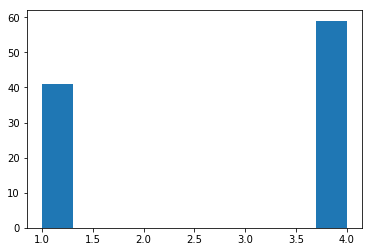

In [652]:
import matplotlib.pyplot as plt
plt.hist(total_reward)
plt.show()

In [479]:
with tf.Session() as sess:
    init.run()
    print(actor_v1.eval(feed_dict={X_state1: [state[0]]}))
    #print(actor_model_a1([state[0]]))

[[0.12947427 0.10257882 0.0778185  0.09702891 0.10729338 0.10723162
  0.12512033 0.13942996 0.11402424]]


In [ ]:
reward

In [616]:
with tf.Session() as sess:
    init.run()
    #observation, actions, rewards, done = env.step([0,0])
    state = observation
    #Actor evaluate what to do
    q1_values = actor_v1.eval(feed_dict={X_state1: [state[0]]})
    action1 = choose_action(q1_values)
        
    q2_values = actor_v2.eval(feed_dict={X_state2: [state[1]]})
    action2 = choose_action(q2_values)
        
    #Actor plays
    observation, actions, rewards, done = env.step([action1,action2])
    reward += sum(rewards)
            
    next_state = observation
    state = next_state

In [617]:
env.render()

array([[0., 0., 2., 0., 0.],
       [2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [496]:
q1_values

array([[0.12947427, 0.10257882, 0.0778185 , 0.09702891, 0.10729338,
        0.10723162, 0.12512033, 0.13942996, 0.11402424]], dtype=float32)

In [497]:
q2_values

array([[0.14067793, 0.10261201, 0.08120742, 0.09758162, 0.1091956 ,
        0.10892611, 0.11932769, 0.12620208, 0.11426958]], dtype=float32)

In [499]:
action2

0